In [1]:
import pandas as pd
import numpy as np
import time
import seaborn as sns
import matplotlib.pyplot as plt
import requests
from bs4 import BeautifulSoup
import itertools
from copy import deepcopy as dcopy,copy

from z3 import *
from IPython.display import Markdown, display

In [2]:
url='https://www.janestreet.com/puzzles/chess-dance/'
res = requests.get(url)
soup = BeautifulSoup(res.content, 'html.parser')
y =[text for text in soup.body.stripped_strings]

display(Markdown("**"+y[6]+"**\n\n"+str(" ".join(y[7:26]))))

**Chess Dance**

Five chess pieces are placed on a chessboard:  a Q ueen, K ing, R ook, B ishop, and k N ight, as shown. They all move simultaneously, and finish at squares that we’ll label Q1, K1, B1, R1, and N1.  They continue moving, and no square is ever visited more than once, for a total of 8 moves .  (So in total, 45 squares will be labeled:  Q0 through Q8, K0 through K8, etc.) Pieces move according to the same rules as chess (e.g. a Rook can move anywhere along its row or column).  After each move, no piece is allowed to be under attack from any other piece. The numbers along the rows and columns presented here are the products of the non-zero numbers that were visible after only 7 moves After all 8 moves are finished, the 8 row products and the 8 column products are recalculated (non-zero numbers only). The answer to this month’s puzzle is the largest possible sum for these 16 products.

<img src="https://www.janestreet.com/puzzles/wp-content/uploads/2016/09/sep16_puzzle.png" width=350>

In [3]:
col_tot = [2744,36,375,336,108,240,20,504]
row_tot = [7,1890,8,10080,20,840,144,1260]

Solved in 339.87 seconds
The sum of products is 62,943



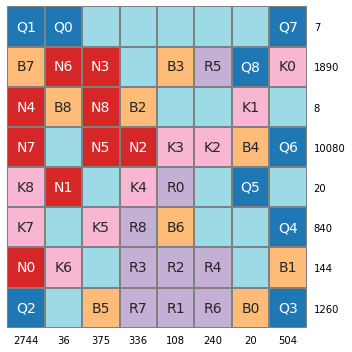

In [13]:
start = time.time()
s = Optimize()

#set up the variables
Q = [Int("Q_%s" % (i+1)) for i in range(9) ]
K = [Int("K_%s" % (i+1)) for i in range(9) ]
R = [Int("R_%s" % (i+1)) for i in range(9) ]
N = [Int("N_%s" % (i+1)) for i in range(9) ]
B = [Int("B_%s" % (i+1)) for i in range(9) ]

# add the objective
s.maximize(Sum([Product([If(i % 8==x,y,1) for y in range(1,9) for i in [Q[y],K[y],R[y],N[y],B[y]]]) +
               Product([If(i / 8==x,y,1) for y in range(1,9) for i in [Q[y],K[y],R[y],N[y],B[y]]])
               for x in range(8)]))

#fixed
s += Q[0] == 8
s += Q[8] == 49
s += K[0] == 57
s += R[0] == 36
s += N[0] == 6
s += B[0] == 55


# using some of the solutions to test
b_solve = [55,62,26,33,51,23,37,1,10]
q_solve = [8,0,7,63,61,52,59,56,49]
k_solve = [57,50,43,35,28,21,14,5,4]
r_solve = [36,39,38,30,46,41,47,31,29]
n_solve = [6,12,27,17,2,19,9,3,18]

n=4
s+= [Q[i] == q_solve[i] for i in range(n)]
s+= [K[i] == k_solve[i] for i in range(n)]
s+= [R[i] == r_solve[i] for i in range(n)]
s+= [N[i] == n_solve[i] for i in range(n)]
s+= [B[i] == b_solve[i] for i in range(n)]

#distinct placements on the board 
pieces = Q+K+R+N+B
 
s += Distinct([i for i in pieces])
s += [And(i>-1,i<64) for i in pieces]

# valid moves
a = [(i,j) for i,j in itertools.product((1, -1),(2,-2))]
n_moves = a + [tuple(reversed(m)) for m in a]
r_moves = [f(i) for i in range(1,8) for f in [lambda x:(x,0),lambda x:(0,x),lambda x:(0,-x),lambda x:(-x,0)]]
k_moves = [(i,j) for (i,j) in itertools.product([-1,0,1],[-1,0,1]) if (i,j) != (0,0)]
b_moves = [f(i) for i in range(1,8) for f in [lambda x:(x,x),lambda x:(-x,x),lambda x:(x,-x),lambda x:(-x,-x)]]
q_moves = b_moves+r_moves

s += [Or([And(Q[i]%8 - Q[i-1]%8 == x,Q[i]/8 - Q[i-1]/8 == y) for x,y in q_moves]) for i in range(1,9)]
s += [Or([And(K[i]%8 - K[i-1]%8 == x,K[i]/8 - K[i-1]/8 == y) for x,y in k_moves]) for i in range(1,9)]
s += [Or([And(R[i]%8 - R[i-1]%8 == x,R[i]/8 - R[i-1]/8 == y) for x,y in r_moves]) for i in range(1,9)]
s += [Or([And(N[i]%8 - N[i-1]%8 == x,N[i]/8 - N[i-1]/8 == y) for x,y in n_moves]) for i in range(1,9)]
s += [Or([And(B[i]%8 - B[i-1]%8 == x,B[i]/8 - B[i-1]/8 == y) for x,y in b_moves]) for i in range(1,9)]

# not under attack
s += [And([Not(And(K[i]%8 - Q[i]%8 == x,K[i]/8 - Q[i]/8 == y)) for x,y in q_moves]) for i in range(1,9)]
s += [And([Not(And(R[i]%8 - Q[i]%8 == x,R[i]/8 - Q[i]/8 == y)) for x,y in q_moves]) for i in range(1,9)]
s += [And([Not(And(N[i]%8 - Q[i]%8 == x,N[i]/8 - Q[i]/8 == y)) for x,y in q_moves]) for i in range(1,9)]
s += [And([Not(And(B[i]%8 - Q[i]%8 == x,B[i]/8 - Q[i]/8 == y)) for x,y in q_moves]) for i in range(1,9)]

s += [And([Not(And(Q[i]%8 - K[i]%8 == x,Q[i]/8 - K[i]/8 == y)) for x,y in k_moves]) for i in range(1,9)]
s += [And([Not(And(R[i]%8 - K[i]%8 == x,R[i]/8 - K[i]/8 == y)) for x,y in k_moves]) for i in range(1,9)]
s += [And([Not(And(N[i]%8 - K[i]%8 == x,N[i]/8 - K[i]/8 == y)) for x,y in k_moves]) for i in range(1,9)]
s += [And([Not(And(B[i]%8 - K[i]%8 == x,B[i]/8 - K[i]/8 == y)) for x,y in k_moves]) for i in range(1,9)]

s += [And([Not(And(Q[i]%8 - R[i]%8 == x,Q[i]/8 - R[i]/8 == y)) for x,y in r_moves]) for i in range(1,9)]
s += [And([Not(And(K[i]%8 - R[i]%8 == x,K[i]/8 - R[i]/8 == y)) for x,y in r_moves]) for i in range(1,9)]
s += [And([Not(And(N[i]%8 - R[i]%8 == x,N[i]/8 - R[i]/8 == y)) for x,y in r_moves]) for i in range(1,9)]
s += [And([Not(And(B[i]%8 - R[i]%8 == x,B[i]/8 - R[i]/8 == y)) for x,y in r_moves]) for i in range(1,9)]

s += [And([Not(And(Q[i]%8 - N[i]%8 == x,Q[i]/8 - N[i]/8 == y)) for x,y in n_moves]) for i in range(1,9)]
s += [And([Not(And(K[i]%8 - N[i]%8 == x,K[i]/8 - N[i]/8 == y)) for x,y in n_moves]) for i in range(1,9)]
s += [And([Not(And(R[i]%8 - N[i]%8 == x,R[i]/8 - N[i]/8 == y)) for x,y in n_moves]) for i in range(1,9)]
s += [And([Not(And(B[i]%8 - N[i]%8 == x,B[i]/8 - N[i]/8 == y)) for x,y in n_moves]) for i in range(1,9)]

s += [And([Not(And(Q[i]%8 - B[i]%8 == x,Q[i]/8 - B[i]/8 == y)) for x,y in b_moves]) for i in range(1,9)]
s += [And([Not(And(K[i]%8 - B[i]%8 == x,K[i]/8 - B[i]/8 == y)) for x,y in b_moves]) for i in range(1,9)]
s += [And([Not(And(R[i]%8 - B[i]%8 == x,R[i]/8 - B[i]/8 == y)) for x,y in b_moves]) for i in range(1,9)]
s += [And([Not(And(N[i]%8 - B[i]%8 == x,N[i]/8 - B[i]/8 == y)) for x,y in b_moves]) for i in range(1,9)]

# row_col sums
for x in range(8):
    s += row_tot[x] == Product([If(i % 8==x,y,1) for y in range(1,8) for i in [Q[y],K[y],R[y],N[y],B[y]]])
    s += col_tot[x] == Product([If(i / 8==x,y,1) for y in range(1,8) for i in [Q[y],K[y],R[y],N[y],B[y]]])
    
if s.check() == sat:
    m = s.model()
    q = [m.evaluate(Q[i]).as_long() for i in range(9)]
    k = [m.evaluate(K[i]).as_long() for i in range(9)]
    r = [m.evaluate(R[i]).as_long() for i in range(9)]
    n = [m.evaluate(N[i]).as_long() for i in range(9)]
    b = [m.evaluate(B[i]).as_long() for i in range(9)]
    print("Solved in {:.2f} seconds".format(time.time()-start))

    board= [["" for i in range(8)] for j in range(8)]
    colours = np.zeros((8,8))
    prod = np.zeros((8,8))
    for i in range(9):
        board[q[i] % 8][q[i] // 8] = "Q%s"% i
        board[k[i] % 8][k[i] // 8] = "K%s"% i        
        board[r[i] % 8][r[i] // 8] = "R%s"% i        
        board[n[i] % 8][n[i] // 8] = "N%s"% i        
        board[b[i] % 8][b[i] // 8] = "B%s"% i        
        colours[q[i] % 8][q[i] // 8] = 6
        colours[k[i] % 8][k[i] // 8] = 2
        colours[r[i] % 8][r[i] // 8] = 3
        colours[n[i] % 8][n[i] // 8] = 4
        colours[b[i] % 8][b[i] // 8] = 5
        prod[q[i] % 8][q[i] // 8] = i
        prod[k[i] % 8][k[i] // 8] = i
        prod[r[i] % 8][r[i] // 8] = i
        prod[n[i] % 8][n[i] // 8] = i
        prod[b[i] % 8][b[i] // 8] = i    
    
    prod[prod==0] = 1
    
    soln = np.sum(np.product(prod,0))+np.sum(np.product(prod,1))
    print("The sum of products is {:,.0f}\n".format(soln))
        
    fig,ax = plt.subplots(1,1,figsize=(5,5))    
    ax =sns.heatmap(colours,annot=board,cbar=False,cmap="tab20_r",fmt="",linewidths=1,linecolor="grey",annot_kws={"size":14},
                    xticklabels=col_tot, yticklabels=row_tot)
    ax.tick_params(left=False, bottom=False,labelleft=False, labelright=True)
    plt.xticks(rotation=0,fontsize =10)
    plt.yticks(rotation=0,fontsize =10)
    plt.tight_layout()
    plt.show()   
else:
    print("failed to solve")  

In [5]:
url='https://www.janestreet.com/puzzles/solutions/september-2016-solution/'
res = requests.get(url)
soup = BeautifulSoup(res.content, 'html.parser')
x =[text for text in soup.body.stripped_strings]

print("Solution")
print("~~~~~~~~")
print(" ".join(x[7:11]))

Solution
~~~~~~~~
There’s quite a bit of logic to sift through with this month’s puzzle, but when the dust settles, this is the completed grid that maximizes the sum of the 16 products, which is 62,943 .   Congratulations to everyone who managed to crack this one! Correct Submissions:


<img src="https://www.janestreet.com/puzzles/wp-content/uploads/2016/10/sep16_solution.png" width=450>

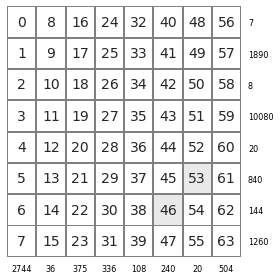

In [6]:
board= [["" for i in range(8)] for j in range(8)]
for i in range(64):
    board[i % 8][i // 8] = i
    
colours=np.zeros((8,8))

n_moves = [(2, 1), (1, 2), (-1, 2), (-2, 1), (-2, -1), (-1, -2), (1, -2), (2, -1)]


for i,j in itertools.product(range(8),range(8)):
    sq =63
    n,m = (sq % 8,sq // 8)
    if board[i][j] in [(n+x)*8+(n+y)  for (x,y) in n_moves if n+x >=0 and n+x < 8 and m+y >=0 and m+y <8 ]:
        colours[i,j] = 1

fig,ax = plt.subplots(1,1,figsize=(4,4))    
ax =sns.heatmap(colours,annot=board,cbar=False,center=3,cmap="Greys",fmt="",linewidths=1,linecolor="grey",annot_kws={"size":14},
                    xticklabels=col_tot, yticklabels=row_tot)
ax.tick_params(left=False, bottom=False,labelleft=False, labelright=True)
plt.xticks(rotation=0,fontsize =8)
plt.yticks(rotation=0,fontsize =8)
plt.tight_layout()
plt.show()   


In [7]:
b_solve = [55,62,26,33,51,23,37,1,10]
q_solve = [8,0,7,63,61,52,59,56,49]
k_solve = [57,50,43,35,28,21,14,5,4]
r_solve = [36,39,38,30,46,41,47,31,29]
n_solve = [6,12,27,17,2,19,9,3,18]
s+= [Q[i] == q_solve[i] for i in range(9)]
s+= [K[i] == k_solve[i] for i in range(9)]
s+= [R[i] == r_solve[i] for i in range(9)]
s+= [N[i] == n_solve[i] for i in range(9)]
s+= [B[i] == b_solve[i] for i in range(9)]

In [8]:
[(i,j) for (i,j) in itertools.product([-1,0,1],[-1,0,1]) if (i,j) != (0,0)]

[(-1, -1), (-1, 0), (-1, 1), (0, -1), (0, 1), (1, -1), (1, 0), (1, 1)]

In [9]:
a = list(itertools.product( (1, -1), (2,-2)))
k_moves = a + [tuple(reversed(m)) for m in a]